In [99]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# Analysis

In [100]:
mode1 = 'nh'
iout1 = 1026
repo, rurmode, dp = mode2repo(mode1)
nh1 = uri.RamsesSnapshot(repo, iout1, mode=rurmode)
nhs1 = uri.TimeSeries(nh1)
nhs1.read_iout_avail()
nout1 = nhs1.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(nh1, galaxy=True, double_precision=dp)
hals1 = uhmi.HaloMaker.load(nh1, galaxy=False, double_precision=dp)
database1 = f"/home/jeon/MissingSat/database"
LG1 = pklload(f"{database1}/LG")
keys1 = []
for key in LG1.keys():
    if(LG1[key]['isLG']): keys1.append(key)
keys1 = np.array(keys1)

mode2 = 'nh2'
iout2 = 797
repo, rurmode, dp = mode2repo(mode2)
nh2 = uri.RamsesSnapshot(repo, iout2, mode=rurmode)
nhs2 = uri.TimeSeries(nh2)
nhs2.read_iout_avail()
nout2 = nhs2.iout_avail['iout']
gals2 = uhmi.HaloMaker.load(nh2, galaxy=True, double_precision=dp)
hals2 = uhmi.HaloMaker.load(nh2, galaxy=False, double_precision=dp)
database2 = f"/home/jeon/MissingSat/database/nh2"
LG2 = pklload(f"{database2}/LG")
keys2 = []
for key in LG2.keys():
    if(LG2[key]['isLG']): keys2.append(key)
keys2 = np.array(keys2)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


## Mass Components

In [101]:
allsubs1 = None
states1 = None
for key in LG1.keys():
    subs = LG1[key]['subs']
    real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]
states1 = states1[argsort]

In [102]:
allsubs2 = None
states2 = None
for key in LG2.keys():
    subs = LG2[key]['subs']
    real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]
states2 = states2[argsort]

In [103]:
subs1 = None; dinks1 = None; pairs1 = None; upairs1 = None
for key in keys1:
    tmp = LG1[key]['subs']
    subs1 = tmp if(subs1 is None) else np.hstack((subs1, tmp))

    real = LG1[key]['real']

    dink_hids = real[real['state'] == 'dink']['hid']
    tmp1 = tmp[isin(tmp['id'], dink_hids)]
    if(len(tmp1)>0):
        dinks1 = tmp1 if(dinks1 is None) else np.hstack((dinks1, tmp1))
    pair_hids = real[real['state'] == 'pair']['hid']
    tmp1 = tmp[isin(tmp['id'], pair_hids)]
    if(len(tmp1)>0):
        pairs1 = tmp1 if(pairs1 is None) else np.hstack((pairs1, tmp1))
    upair_hids = real[real['state'] == 'upair']['hid']
    tmp1 = tmp[isin(tmp['id'], upair_hids)]
    if(len(tmp1)>0):
        upairs1 = tmp1 if(upairs1 is None) else np.hstack((upairs1, tmp1))
print(len(subs1), len(dinks1), len(pairs1), len(upairs1))
subs2 = None; dinks2 = None; pairs2 = None; upairs2 = None
for key in keys2:
    tmp = LG2[key]['subs']
    subs2 = tmp if(subs2 is None) else np.hstack((subs2, tmp))

    real = LG2[key]['real']

    dink_hids = real[real['state'] == 'dink']['hid']
    tmp1 = tmp[isin(tmp['id'], dink_hids)]
    if(len(tmp1)>0):
        dinks2 = tmp1 if(dinks2 is None) else np.hstack((dinks2, tmp1))
    pair_hids = real[real['state'] == 'pair']['hid']
    tmp1 = tmp[isin(tmp['id'], pair_hids)]
    if(len(tmp1)>0):
        pairs2 = tmp1 if(pairs2 is None) else np.hstack((pairs2, tmp1))
    upair_hids = real[real['state'] == 'upair']['hid']
    tmp1 = tmp[isin(tmp['id'], upair_hids)]
    if(len(tmp1)>0):
        upairs2 = tmp1 if(upairs2 is None) else np.hstack((upairs2, tmp1))
print(len(subs2), len(dinks2), len(pairs2), len(upairs2))

1336 1145 130 61
1242 1120 79 43


NH

In [104]:
rname='Rvir'; mass_name='mvir'; xlabel='log($M_{vir}/M_\odot$)'
mass_suffix = "" if(mass_name=='mdm') else "_vir"
if(not os.path.exists(f"03_components.png")):
    fig, axes = plt.subplots(ncols=3, dpi=300, figsize=(12,8), sharey=True)

    samples = [dinks1, pairs1, upairs1]
    names = ["dink", "pair", "UDG"]
    titles = ["Starless Subhalo", "Subhalo-Satellite Pair", "UDG-like Subhalo"]
    for i in range(3):
        ax = axes[i]
        sample = samples[i]
        mask = sample[f'mcold{mass_suffix}'] < 1e3; sample[f'mcold{mass_suffix}'][mask] = 1e3
        mask = sample[f'mstar{mass_suffix}'] < 1e3; sample[f'mstar{mass_suffix}'][mask] = 1e3
        hascolds = sample[f'mcold{mass_suffix}']>1e3
        for iarr in tqdm(sample):
            hascold = iarr[f'mcold{mass_suffix}']>1e3
            color = 'k' if(not hascold) else 'deepskyblue'
            lw = 0.15 if(not hascold) else 0.3
            facecolor='none'# if(isdink) else color
            edgecolor=color# if(isdink) else 'none' 
            linecolor=color
            if(i==0): lw/=2
            

            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mstar{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='*')
            if(iarr[f'mcold{mass_suffix}']>1e3): ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcold{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='H')
            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw)
            if(i>0):
                vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
                if(iarr[f'mcold{mass_suffix}']>1e3): 
                    vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])]), 3 )
                else:
                    vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )
                ax.plot([np.log10(iarr[mass_name]),np.log10(iarr[mass_name])], [vmin, vmax], color=linecolor, lw=0.1)

        ax.text(0.03, 0.95, f"{titles[i]}", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes, family='serif')
        ax.text(0.03, 0.90, fr"$\mathtt{{ \ N_{{{names[i]}}}: {len(sample)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
        ax.text(0.03, 0.85, fr"$\mathtt{{ \ N_{{hasCold}}: {np.sum(hascolds)}({np.sum(hascolds)/len(sample)*100:.1f}\%) }}$", ha='left', va='top', color='deepskyblue', fontsize=9, transform=ax.transAxes)

    icol = 0
    for ax in axes.flatten():
        ax.fill_between([7.9,12.1],3, np.log10(np.min(gals1['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

        ax.set_xlim(8,11.99)
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
        ax.set_ylim(3.01,12)
        if(icol==0): ax.set_ylabel(fr"$\log\ M_{{{rname}}}/M_{{\odot}}$")
        ax.set_xlabel(xlabel)
        icol += 1


    # Making Legend
    from matplotlib.lines import Line2D
    axes[0].set_aspect(1/2)
    axes[1].set_aspect(1/2)
    axes[2].set_aspect(1/2)
    legend_elements = [
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
        Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
        Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
        Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='deepskyblue', markersize=8, label='  Yes'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
    ]

    plt.subplots_adjust(hspace=0, wspace=0)
    axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 1), fontsize=8, ncols=2)

    plt.savefig(f"03_components.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

NH2

  0%|          | 0/1120 [00:00<?, ?it/s]

/tmp/ipykernel_33350/1800644081.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw)


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

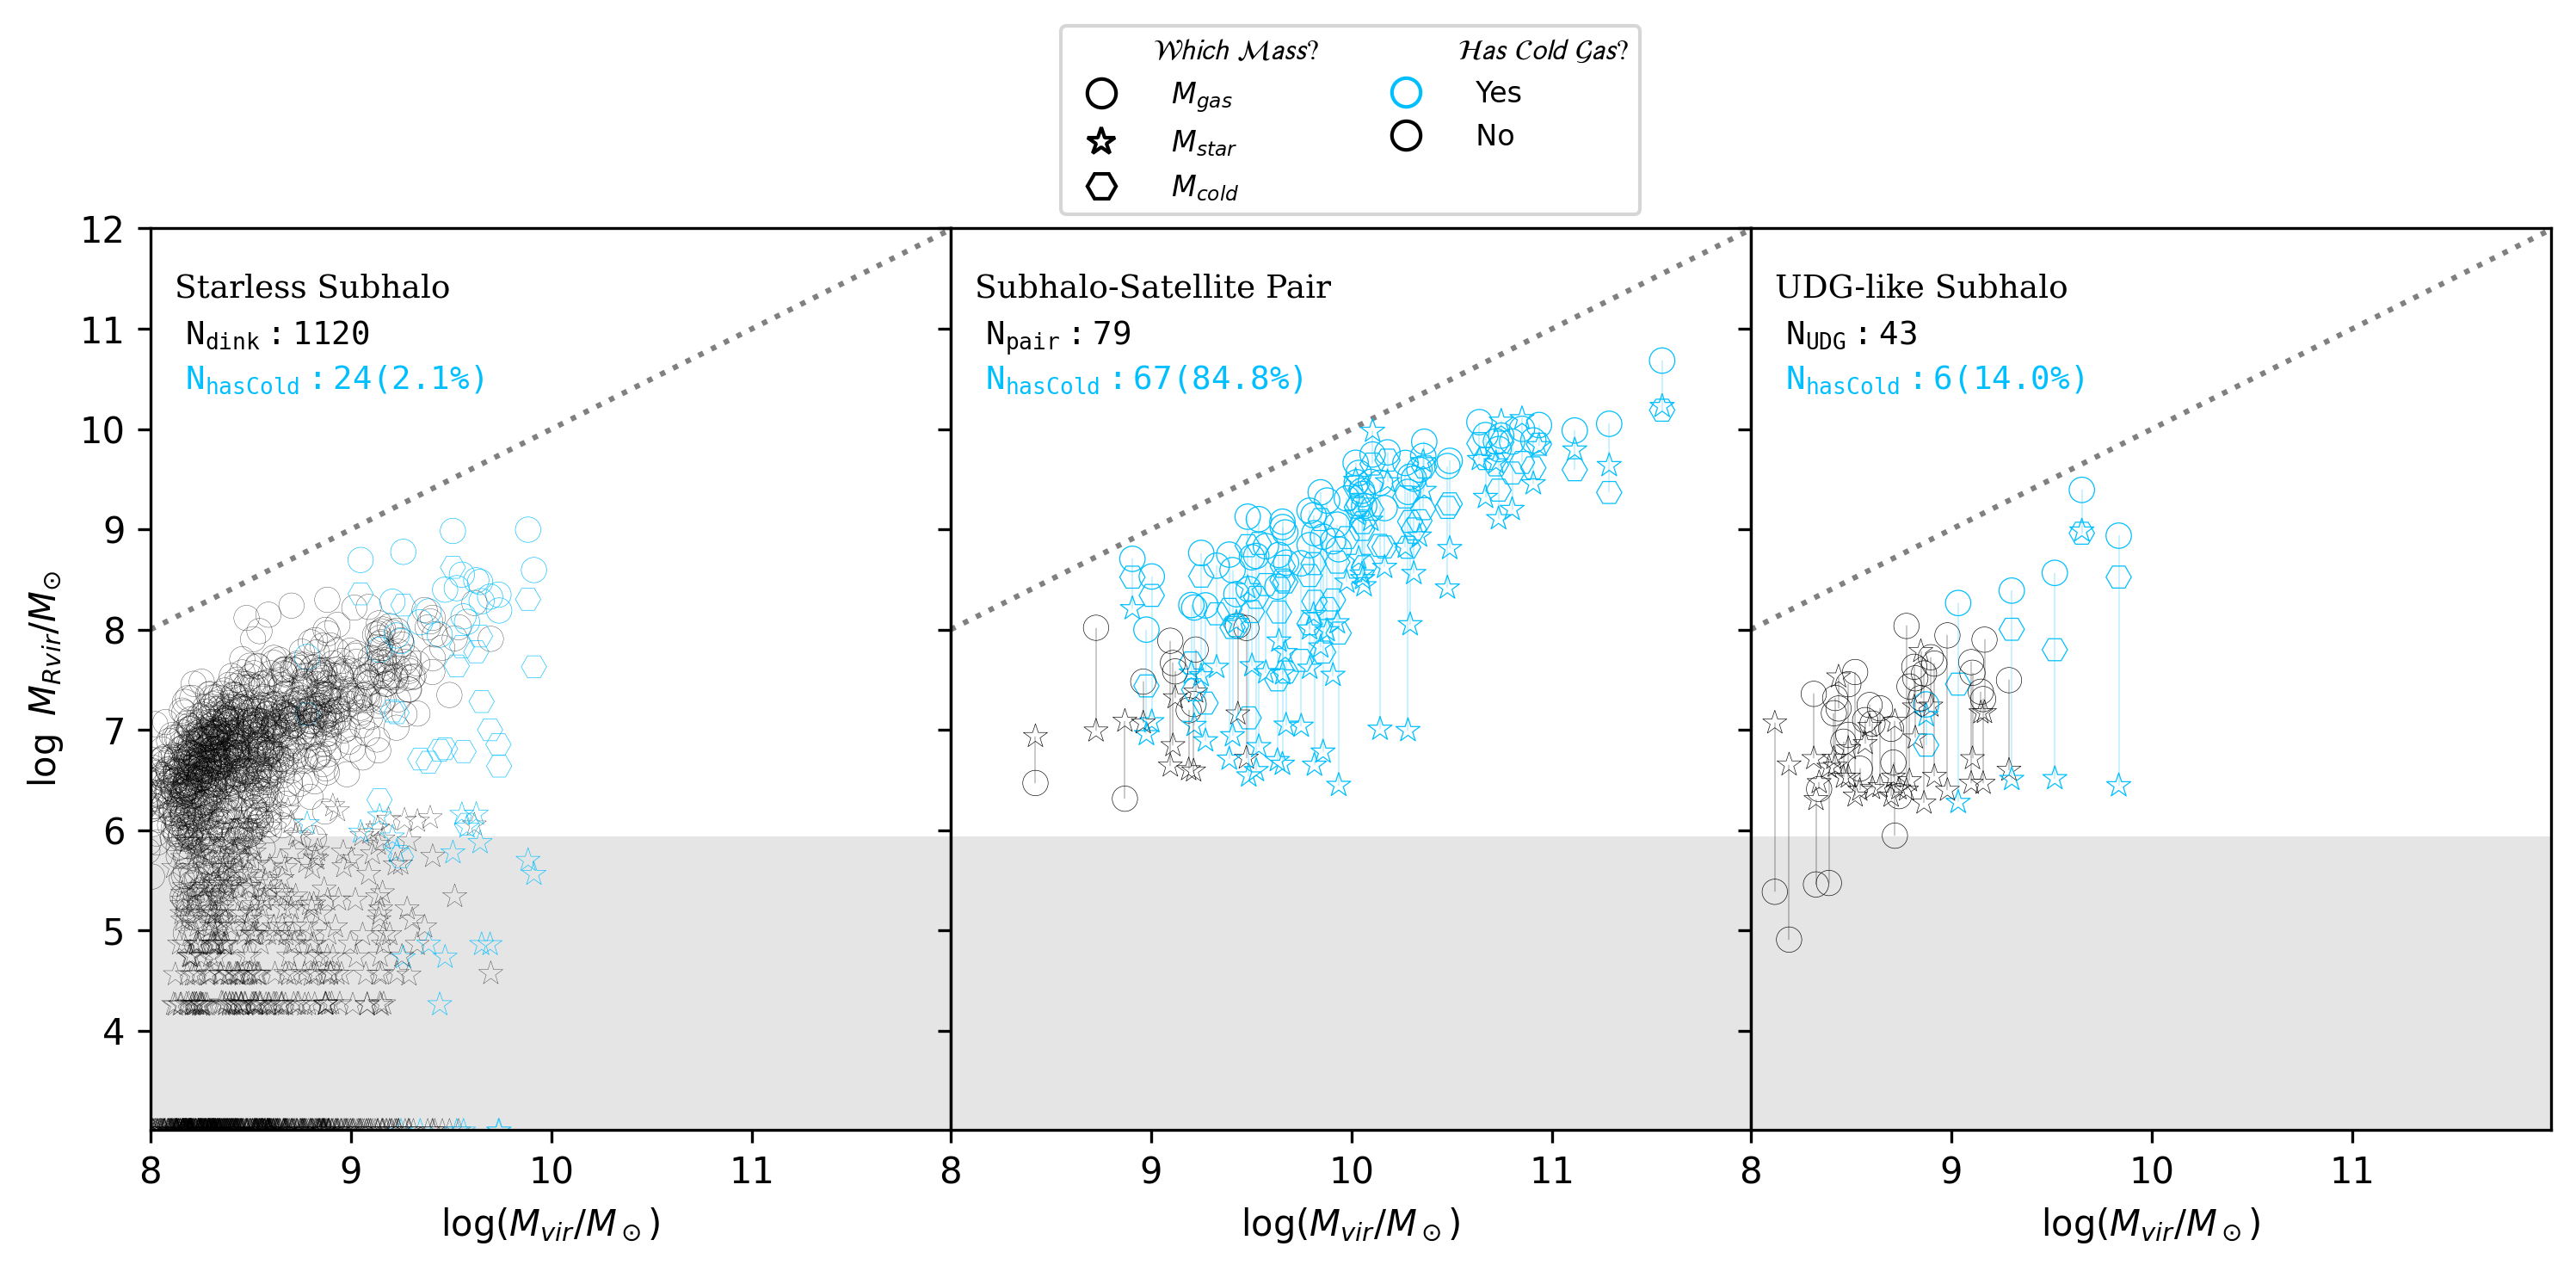

In [105]:
rname='Rvir'; mass_name='mvir'; xlabel='log($M_{vir}/M_\odot$)'
mass_suffix = "" if(mass_name=='mdm') else "_vir"
if(not os.path.exists(f"03_components_nh2.png")):
    fig, axes = plt.subplots(ncols=3, dpi=300, figsize=(12,8), sharey=True)

    samples = [dinks2, pairs2, upairs2]
    names = ["dink", "pair", "UDG"]
    titles = ["Starless Subhalo", "Subhalo-Satellite Pair", "UDG-like Subhalo"]
    for i in range(3):
        ax = axes[i]
        sample = samples[i]
        mask = sample[f'mcold{mass_suffix}'] < 1e3; sample[f'mcold{mass_suffix}'][mask] = 1e3
        mask = sample[f'mstar{mass_suffix}'] < 1e3; sample[f'mstar{mass_suffix}'][mask] = 1e3
        hascolds = sample[f'mcold{mass_suffix}']>1e3
        for iarr in tqdm(sample):
            hascold = iarr[f'mcold{mass_suffix}']>1e3
            color = 'k' if(not hascold) else 'deepskyblue'
            lw = 0.15 if(not hascold) else 0.3
            facecolor='none'# if(isdink) else color
            edgecolor=color# if(isdink) else 'none' 
            linecolor=color
            if(i==0): lw/=2
            

            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mstar{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='*')
            if(iarr[f'mcold{mass_suffix}']>1e3): ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcold{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='H')
            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw)
            if(i>0):
                vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
                if(iarr[f'mcold{mass_suffix}']>1e3): 
                    vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])]), 3 )
                else:
                    vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )
                ax.plot([np.log10(iarr[mass_name]),np.log10(iarr[mass_name])], [vmin, vmax], color=linecolor, lw=0.1)

        ax.text(0.03, 0.95, f"{titles[i]}", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes, family='serif')
        ax.text(0.03, 0.90, fr"$\mathtt{{ \ N_{{{names[i]}}}: {len(sample)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
        ax.text(0.03, 0.85, fr"$\mathtt{{ \ N_{{hasCold}}: {np.sum(hascolds)}({np.sum(hascolds)/len(sample)*100:.1f}\%) }}$", ha='left', va='top', color='deepskyblue', fontsize=9, transform=ax.transAxes)

    icol = 0
    for ax in axes.flatten():
        ax.fill_between([7.9,12.1],3, np.log10(np.min(gals1['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

        ax.set_xlim(8,11.99)
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
        ax.set_ylim(3.01,12)
        if(icol==0): ax.set_ylabel(fr"$\log\ M_{{{rname}}}/M_{{\odot}}$")
        ax.set_xlabel(xlabel)
        icol += 1


    # Making Legend
    from matplotlib.lines import Line2D
    axes[0].set_aspect(1/2)
    axes[1].set_aspect(1/2)
    axes[2].set_aspect(1/2)
    legend_elements = [
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
        Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
        Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
        Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='deepskyblue', markersize=8, label='  Yes'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
    ]

    plt.subplots_adjust(hspace=0, wspace=0)
    axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 1), fontsize=8, ncols=2)

    plt.savefig(f"03_components_nh2.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

## Size Mass Relation

### NH

In [58]:
m1d, m2d = np.nanpercentile(dinks1['mvir'], q=[2.5,97.5])
m1p, m2p = np.nanpercentile(pairs1['mvir'], q=[2.5,97.5])
m1u, m2u = np.nanpercentile(upairs1['mvir'], q=[2.5,97.5])
print(np.log10(m1d),np.log10(m2d))
print(np.log10(m1p),np.log10(m2p))
print(np.log10(m1u),np.log10(m2u))
m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])
print(np.log10(m1), np.log10(m2))

7.941755305898903 9.315764566860231
8.31371869204489 10.841244642558857
8.176378343551688 9.555328932761551
8.31371869204489 9.315764566860231


In [59]:
mbins = np.linspace(7,12,9)
mleng = len(mbins)-1
xs = 0.5*(mbins[1:]+mbins[:-1])
colors = ['k', 'r', 'b', 'g']

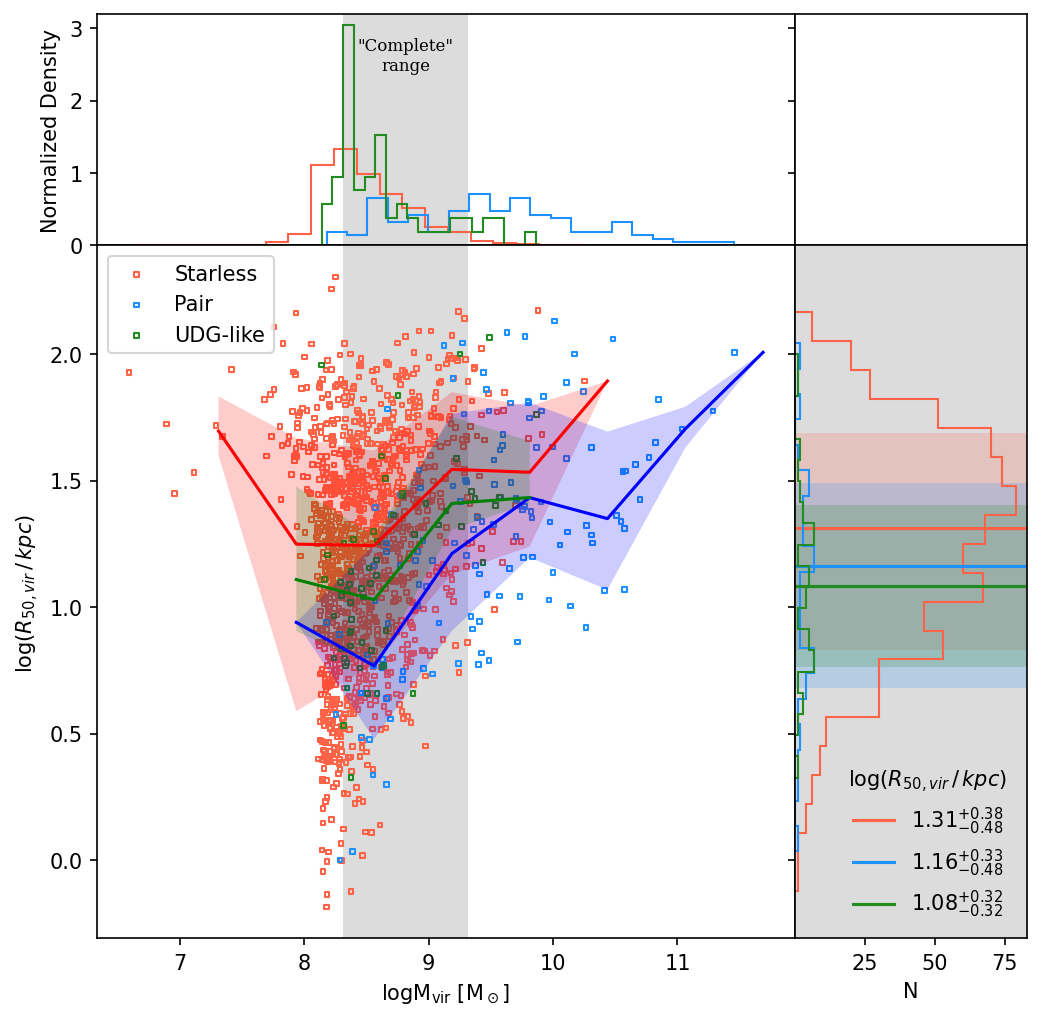

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")

# Dink
color='tomato'
sample = dinks1
val = np.log10( sample['r50_vir']/nh1.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='Starless', marker='s')
colorcount=1
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
sample = pairs1
val = np.log10( sample['r50_vir']/nh1.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='Pair', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
sample = upairs1
val = np.log10( sample['r50_vir']/nh1.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='UDG-like', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'log$(R_{50,vir}\,/\,kpc)$ ', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'log$(R_{50,vir}\,/\,kpc)$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_sizemass.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

### NH2

In [61]:
m1d, m2d = np.nanpercentile(dinks2['mvir'], q=[2.5,97.5])
m1p, m2p = np.nanpercentile(pairs2['mvir'], q=[2.5,97.5])
m1u, m2u = np.nanpercentile(upairs2['mvir'], q=[2.5,97.5])
print(np.log10(m1d),np.log10(m2d))
print(np.log10(m1p),np.log10(m2p))
print(np.log10(m1u),np.log10(m2u))
m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])
print(np.log10(m1), np.log10(m2))

7.973012999629345 9.367707832850863
8.863092311084497 11.122876103292057
8.198286375895975 9.645142940783183
8.863092311084497 9.367707832850863


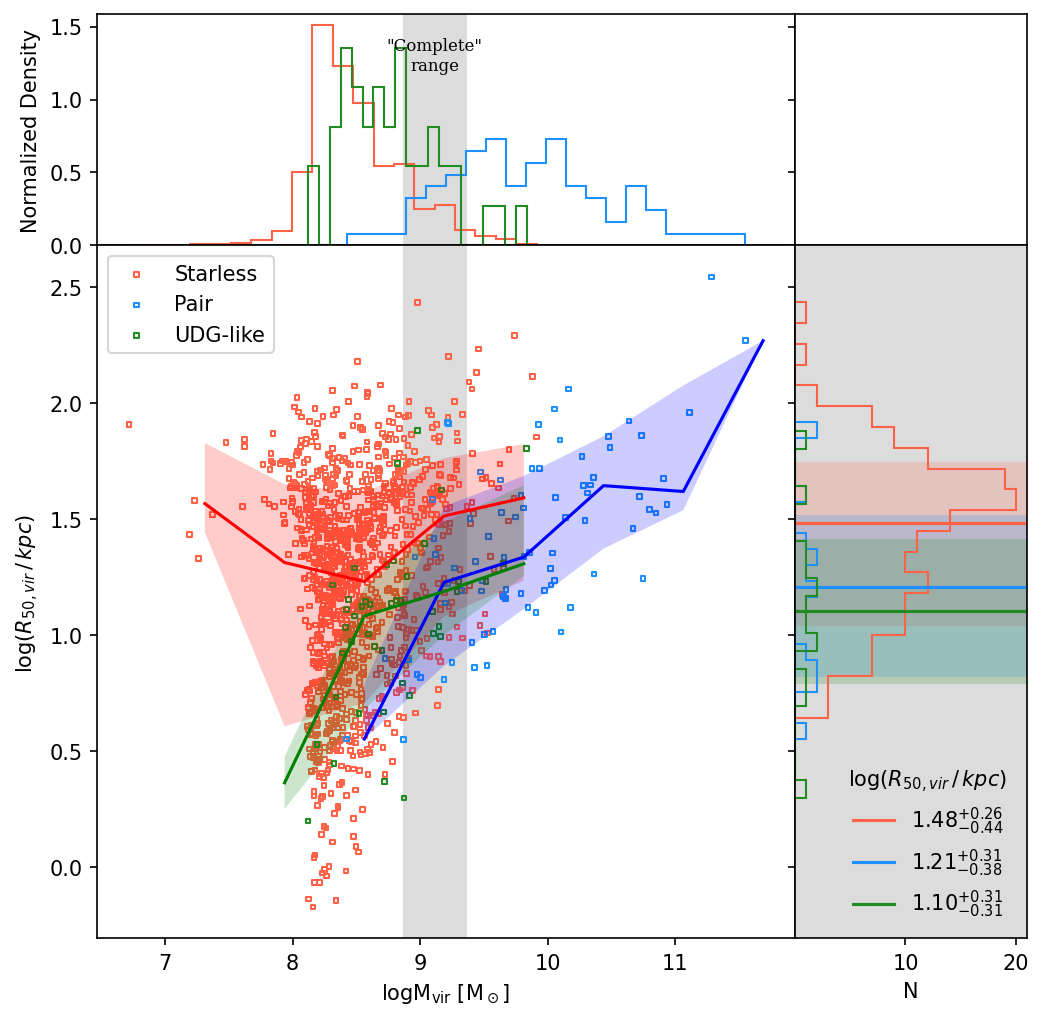

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")

# Dink
color='tomato'
sample = dinks2
val = np.log10( sample['r50_vir']/nh1.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='Starless', marker='s')
colorcount=1
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
sample = pairs2
val = np.log10( sample['r50_vir']/nh1.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='Pair', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
sample = upairs2
val = np.log10( sample['r50_vir']/nh1.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='UDG-like', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'log$(R_{50,vir}\,/\,kpc)$ ', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'log$(R_{50,vir}\,/\,kpc)$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_sizemass_nh2.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

## Inner density slope

NH

In [77]:
fname = f"{database1}/03_inner_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)
denslops = density_slope['slope_vir']
densloperrs = density_slope['err_vir']

In [71]:
denslops.shape, subs1.shape

((3851,), (1336,))

7.941755305898903 9.315764566860231
8.31371869204489 10.841244642558857
8.176378343551688 9.555328932761551
8.31371869204489 9.315764566860231


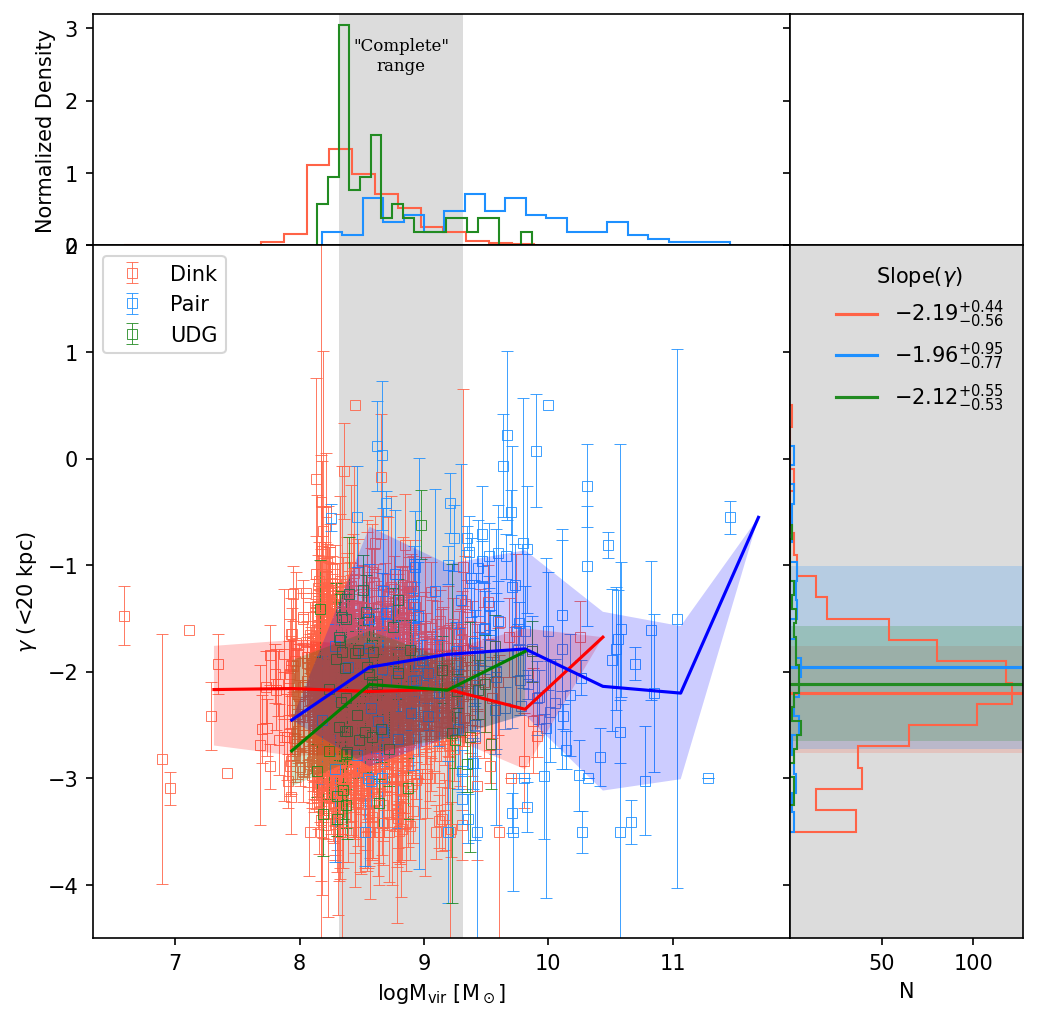

In [78]:


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")


# Dink
color='tomato'
sample = dinks1
mask = isin(allsubs1['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[1], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[1], zorder=6)

complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
sample = pairs1
mask = isin(allsubs1['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[2], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[2], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
sample = upairs1
mask = isin(allsubs1['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[3], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[3], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_innerslope_member.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

NH2

In [79]:
fname = f"{database2}/03_inner_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)
denslops = density_slope['slope_vir']
densloperrs = density_slope['err_vir']

7.973012999629345 9.367707832850863
8.863092311084497 11.122876103292057
8.198286375895975 9.645142940783183
8.863092311084497 9.367707832850863


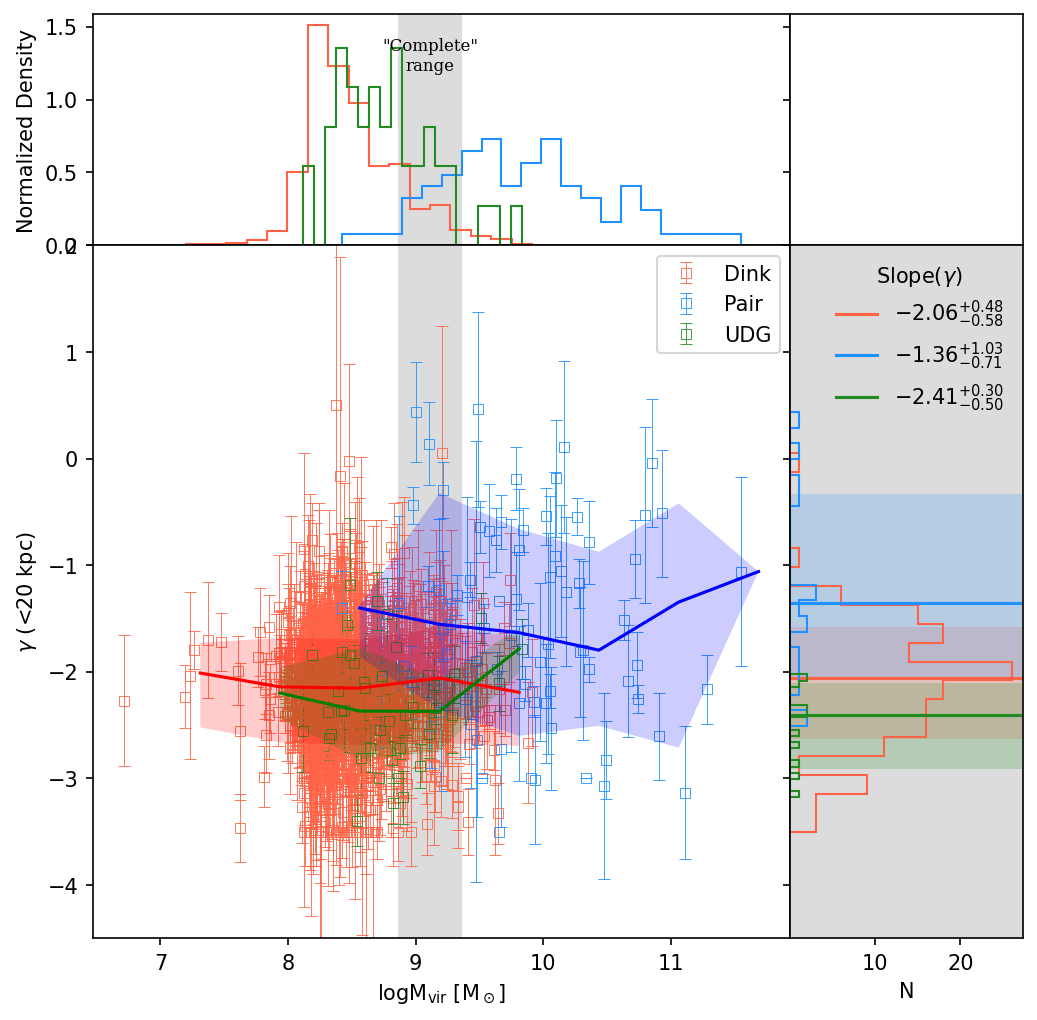

In [80]:
m1d, m2d = np.nanpercentile(dinks2['mvir'], q=[2.5,97.5])
m1p, m2p = np.nanpercentile(pairs2['mvir'], q=[2.5,97.5])
m1u, m2u = np.nanpercentile(upairs2['mvir'], q=[2.5,97.5])
print(np.log10(m1d),np.log10(m2d))
print(np.log10(m1p),np.log10(m2p))
print(np.log10(m1u),np.log10(m2u))
m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])
print(np.log10(m1), np.log10(m2))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")


# Dink
color='tomato'
sample = dinks2
mask = isin(allsubs2['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[1], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[1], zorder=6)

complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
sample = pairs2
mask = isin(allsubs2['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[2], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[2], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
sample = upairs2
mask = isin(allsubs2['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[3], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[3], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_innerslope_member_nh2.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

# Total Density Slope

NH

In [85]:
fname = f"{database1}/03_density_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)
denslops = density_slope['slope_tot']
densloperrs = density_slope['err_tot']

m1d, m2d = np.nanpercentile(dinks1['mvir'], q=[2.5,97.5])
m1p, m2p = np.nanpercentile(pairs1['mvir'], q=[2.5,97.5])
m1u, m2u = np.nanpercentile(upairs1['mvir'], q=[2.5,97.5])
print(np.log10(m1d),np.log10(m2d))
print(np.log10(m1p),np.log10(m2p))
print(np.log10(m1u),np.log10(m2u))
m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])
print(np.log10(m1), np.log10(m2))

7.941755305898903 9.315764566860231
8.31371869204489 10.841244642558857
8.176378343551688 9.555328932761551
8.31371869204489 9.315764566860231


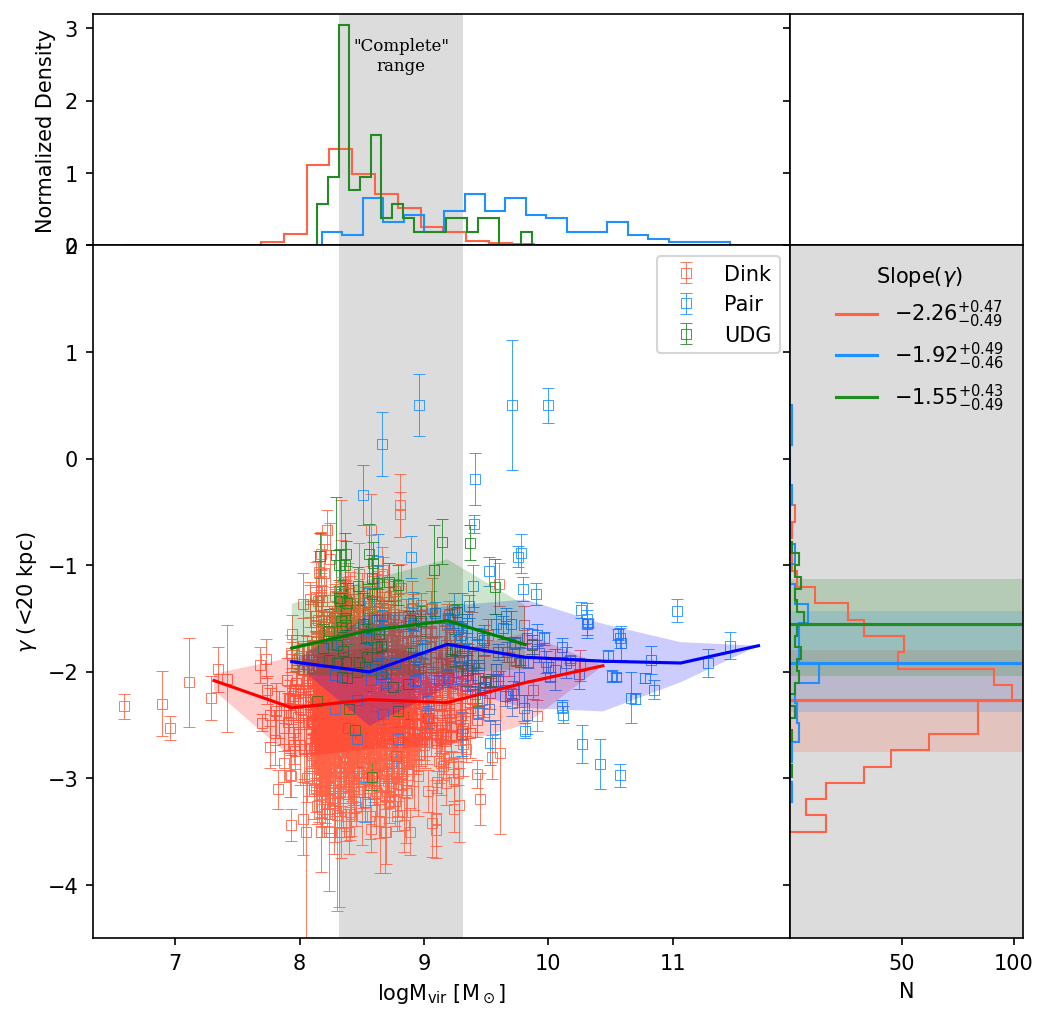

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")


# Dink
color='tomato'
sample = dinks1
mask = isin(allsubs1['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[1], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[1], zorder=6)

complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
sample = pairs1
mask = isin(allsubs1['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[2], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[2], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
sample = upairs1
mask = isin(allsubs1['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[3], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[3], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_totalslope.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

NH2

In [87]:
fname = f"{database2}/03_density_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)
denslops = density_slope['slope_tot']
densloperrs = density_slope['err_tot']

m1d, m2d = np.nanpercentile(dinks2['mvir'], q=[2.5,97.5])
m1p, m2p = np.nanpercentile(pairs2['mvir'], q=[2.5,97.5])
m1u, m2u = np.nanpercentile(upairs2['mvir'], q=[2.5,97.5])
print(np.log10(m1d),np.log10(m2d))
print(np.log10(m1p),np.log10(m2p))
print(np.log10(m1u),np.log10(m2u))
m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])
print(np.log10(m1), np.log10(m2))

7.973012999629345 9.367707832850863
8.863092311084497 11.122876103292057
8.198286375895975 9.645142940783183
8.863092311084497 9.367707832850863


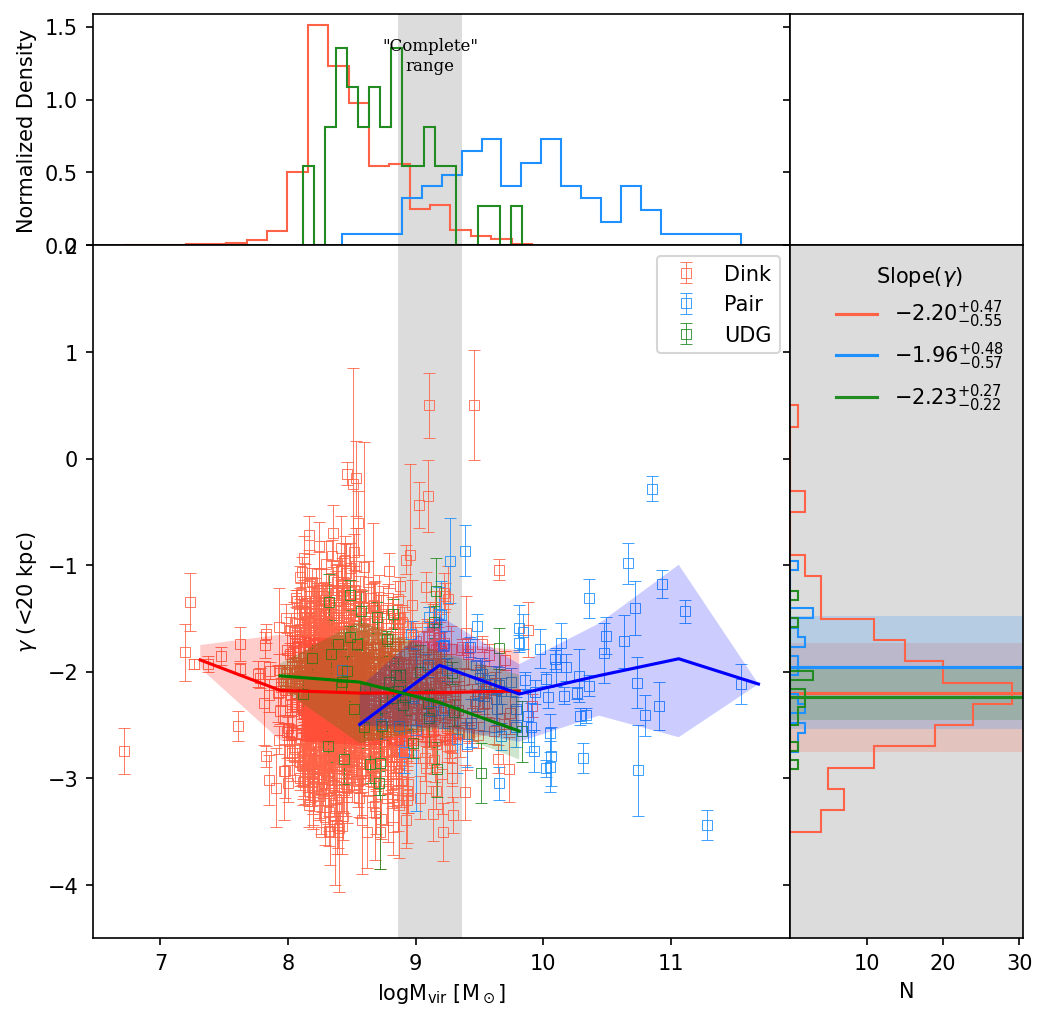

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")


# Dink
color='tomato'
sample = dinks2
mask = isin(allsubs2['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[1], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[1], zorder=6)

complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
sample = pairs2
mask = isin(allsubs2['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[2], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[2], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
sample = upairs2
mask = isin(allsubs2['id'], sample['id'])
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = slopes[mask]
        y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[3], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[3], zorder=6)
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(slopes[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.nanpercentile(slopes[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_totalslope_nh2.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

# sAM

NH

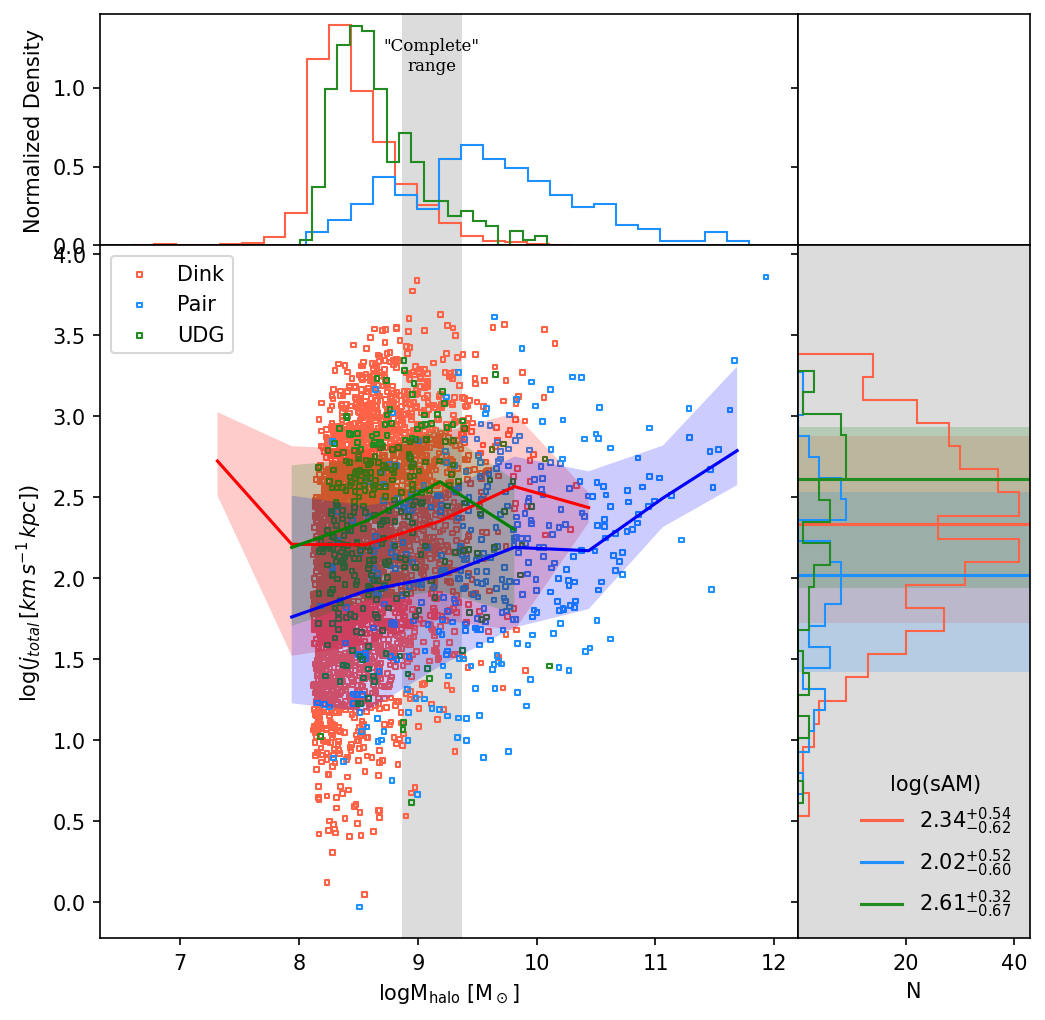

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")

# Dink
color='tomato'
mask = states1=='dink'
sample = allsubs1[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='Dink', marker='s')
colorcount=1
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
mask = states1=='pair'
sample = allsubs1[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='Pair', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
mask = states1=='upair'
sample = allsubs1[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='UDG', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'log(sAM)', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm halo}$ [M$_\odot$]')
ax.set_ylabel(r'log$(j_{total}\,[km\,s^{-1}\,kpc])$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_angmom.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

NH2

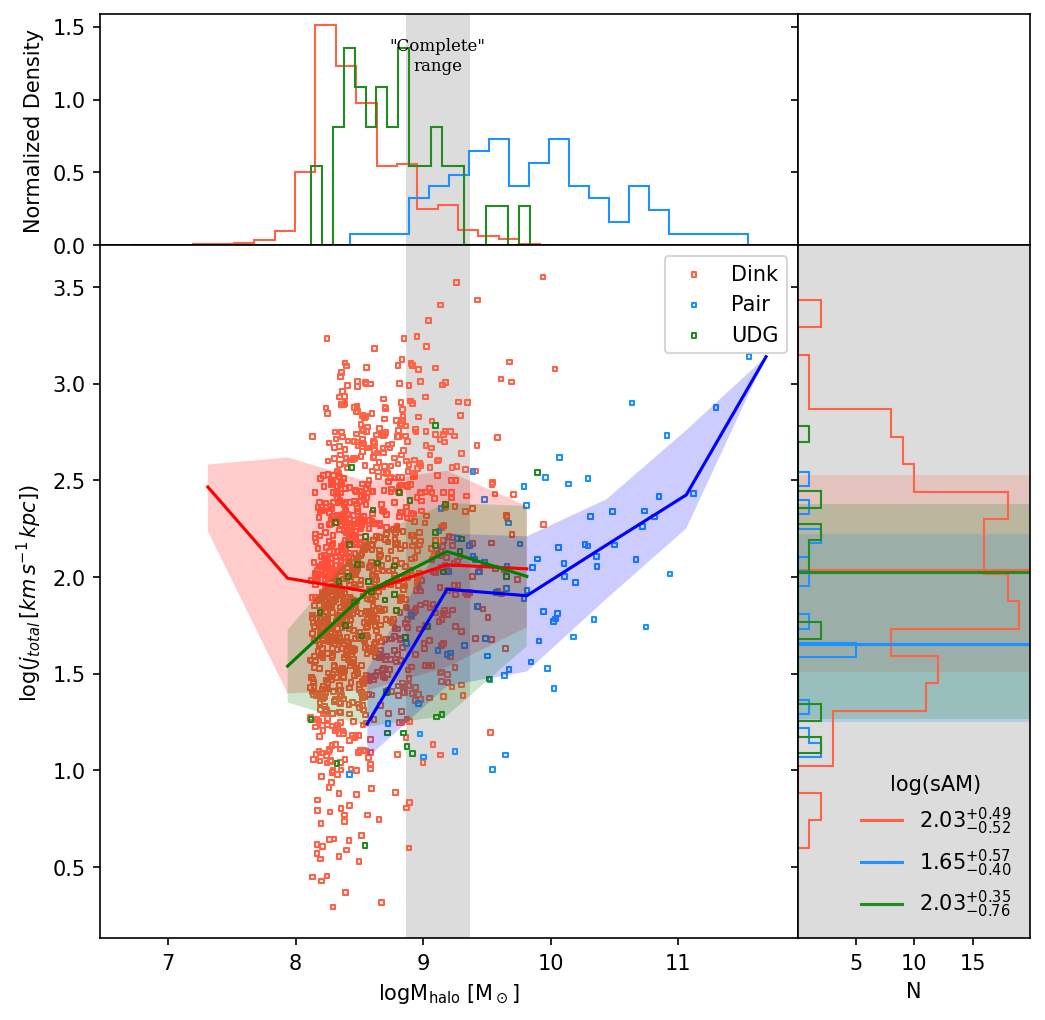

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
ax = axes[1,0]
ax1 = axes[1,1]
ax2 = axes[0,0]
ax2.set_ylabel("Normalized Density")

# Dink
color='tomato'
mask = states2=='dink'
sample = allsubs2[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='Dink', marker='s')
colorcount=1
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# Pair
color='dodgerblue'
mask = states2=='pair'
sample = allsubs2[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='Pair', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

# UDG
color='forestgreen'
mask = states2=='upair'
sample = allsubs2[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='UDG', marker='s')
ys = np.zeros(mleng)-1
y16s = np.zeros(mleng)-1
y84s = np.zeros(mleng)-1
for i in range(mleng):
    mask = (sample['mvir'] >= 10**mbins[i])&(sample['mvir'] < 10**mbins[i+1])
    if(np.sum(mask)>0):
        value = val[mask]
        y16s[i], ys[i], y84s[i] = np.percentile(value, q=[16,50,84])
    else:
        y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
mask = ~np.isnan(ys)
ax.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
ax.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
colorcount+=1
complete = (sample['mvir'] >= m1)&(sample['mvir'] <= m2)
ax1.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val[complete], q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
ax2.hist(np.log10(sample['mvir']), bins=20, color=color, histtype='step', density=True)

ax.legend()
ax1.legend(title=r'log(sAM)', frameon=False)

ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax2.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax1.set_facecolor('gainsboro')
ax2.text((np.log10(m1)+np.log10(m2))/2, ax2.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
ax.set_xlabel(r'logM$_{\rm halo}$ [M$_\odot$]')
ax.set_ylabel(r'log$(j_{total}\,[km\,s^{-1}\,kpc])$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"03_angmom_nh2.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()